This is a vision application of the AIRSAS Image Classification study for my thesis. Inputs are in the form of x by x pixel beamformed images from the AIRSAS. Outputs are the predicted letter present in the scan. The training set consists of imagery of 5,000 numbers generated from MATLAB. In this implementation, several key features will be determined from the generated input imagery to make predictions on AIRSAS imagery.

NOTE: This notebook makes use of the fastai library. Run the code cell below to get the necessary files. 

In [1]:
!pip install fastai==2.1.10

Next, we will need to import all the necessary libraries for this project.

In [2]:
from fastai.vision.all import *
import os
import numpy as np
import random
import pandas as pd
import time
from pathlib import Path
import zipfile as zf
from IPython.display import Image
from PIL import Image, ImageOps

Next, we will allocate the testing parameters for this implementation. Epochs has been set to 100, so the learners will run for 100 epochs. The layer setup has been set to the Fast.AI default. n_classes contains the individual numbers that will be tested.

In [3]:
epochs = 3
#Full n_classes = ['1','2','3','4','5','6','7','8','9','0']
n_classes =  ['1','2','3','4','5','6','7','8','9','0']
print('Training_' + '_'.join([str(elem) for elem in n_classes]))

Training_1_2_3_4_5_6_7_8_9_0


Finally, we will allocate the constants for this implementation. metrics specifies the values our learner model will display per epoch.

In [4]:
metrics = [accuracy,error_rate]

In the next two cells, we will set up the folders needed to organize our input data. Even if the folders are already setup, the first cell must be run in order to allocate the paths used later on.

In [5]:
AIRSAS_Classifier_Data = Path('AIRSAS_Classifier_Data_flipped')
Test_Imagery = Path(str(AIRSAS_Classifier_Data) + '/Test_Imagery')
Train_Imagery = Path(str(AIRSAS_Classifier_Data) + '/Train_Imagery')

This cell makes the directories if they don't exist already.

In [ ]:
AIRSAS_Classifier_Data.mkdir(parents=True, exist_ok=True)
Test_Imagery.mkdir(parents=True, exist_ok=True)
Train_Imagery.mkdir(parents=True, exist_ok=True)

We now have to allocate training data.  Zip all the test image files in a file titled "Train_numbers.zip".
Run this cell to extract all the files.

In [ ]:
files = zf.ZipFile(str(AIRSAS_Classifier_Data) + '/Train_Imagery/Train_numbers.zip', 'r')
files.extractall(str(Train_Imagery))
files.close()
os.remove(str(Train_Imagery) + '/Train_numbers.zip')

I realized that the Matlab script for generated image data was making images that were mirror flipped vertically. Run the next cell to fix this issue.

In [ ]:
os.rmdir(str(Train_Imagery) + '/.ipynb_checkpoints')
for file in os.listdir(Train_Imagery):
  filename = os.fsdecode(file)
  im = Image.open(str(Train_Imagery) + '/' + filename)
  im_flip = ImageOps.flip(im)
  im_flip.save(str(Train_Imagery) + '/' + filename)
  print(filename)

Next step is to allocate the testing data. Zip all of the output images produced by the beamformer script into an archive titled "Test_numbers.zip". Run this cell to extract all the files.

In [32]:
files = zf.ZipFile(str(AIRSAS_Classifier_Data) + "/Test_Imagery/AIRSAS Scans.zip", 'r')
files.extractall(str(Test_Imagery))
files.close()
os.remove(str(Test_Imagery) + '/AIRSAS Scans.zip')

Data Collection on the AIRSAS results in mirrored scans. Run this cell to fix that. 

In [29]:
#os.rmdir(str(Test_Imagery) + '/.ipynb_checkpoints')
PFA = Path(str(Test_Imagery) + '/PFA')
for file in os.listdir(PFA):
  filename = os.fsdecode(file)
  im = Image.open(str(PFA) + '/' + filename)
  im_flip = ImageOps.mirror(im)
  im_flip.save(str(PFA) + '/' + filename)
  print(filename)

FileNotFoundError: [Errno 2] No such file or directory: 'AIRSAS_Classifier_Data_flipped/Test_Imagery/PFA'

To verify that things are functioning, the next cell will choose a random image from the train set.

In [42]:
random_image = random.choice(os.listdir(str(Train_Imagery)))
random_image_path = Path(str(Train_Imagery) + '/' + str(random_image))
print('Random image is: ' + str(random_image))

Random image is: MNIST89_0train_CLEAN.png


The random image is displayed.

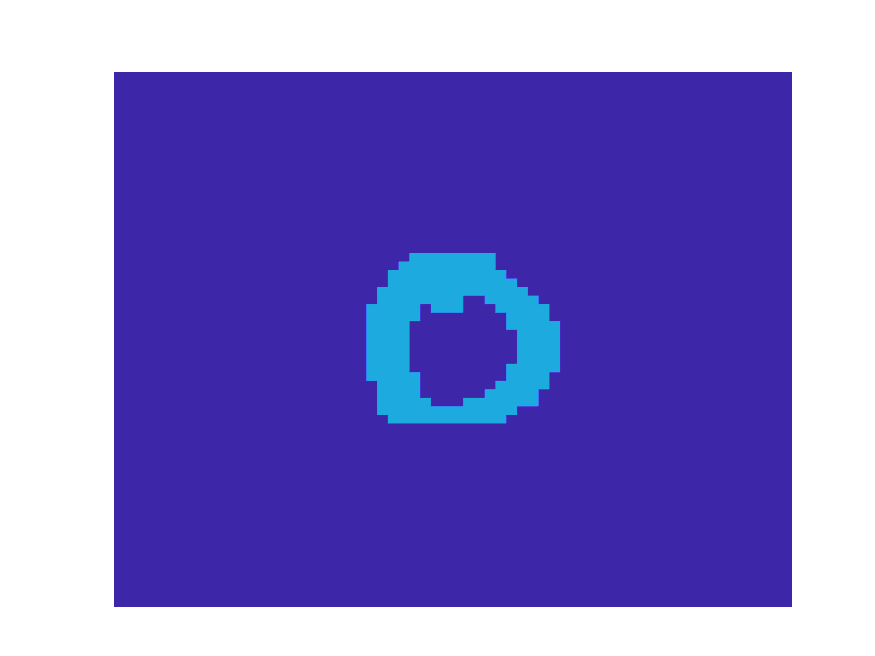

In [43]:
display(Image.open(random_image_path))

The individual classes or genres to be tested.

In [6]:
classes = n_classes
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

This cell allocates the data into a format used by the Fast.ai

In [22]:
files = get_image_files(Train_Imagery)
def label_func(x): return x.name[-16]

dls = ImageDataLoaders.from_path_func(Train_Imagery, files, label_func, batch_size = 10, size = 28)

This cell shows an example batch of values in our dataset.

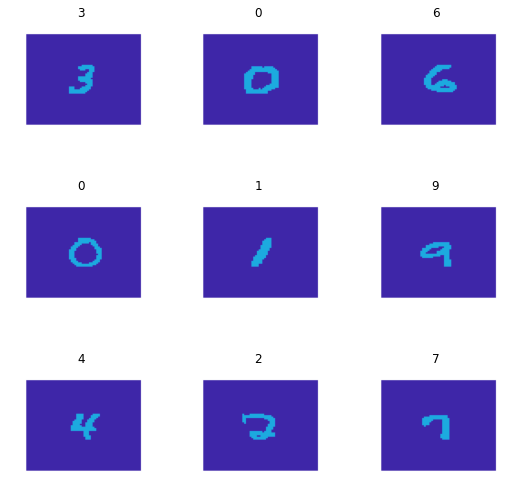

In [9]:
dls.show_batch()

This cell allocates our learner model with the layers and metrics we allocated earlier.

In [23]:
learn = cnn_learner(dls, resnet34, metrics=metrics)

This cell runs the command lr_find(), which will determine some examples for a good learning rate by displaying the learning rate that yeild minimum loss or steepest descent. Either use the default of 3e-3, choose a rate between the two values displayed, or plug the two values into the mean formula below.

In [ ]:
learn.lr_find()

This cell finds the mean between the two learning rate values.

In [ ]:
lr_min=0.003981071710586548
lr_steep=6.309573450380412e-07
lr = (lr_min + lr_steep)/2 

This cell fits our learner to the training set for our specified number of epochs. 

In [24]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.035558,88.384834,0.080000,0.920000,01:08
1,0.557002,13.363585,0.211000,0.789000,01:08
2,0.440897,3.030027,0.520000,0.480000,01:08
3,0.318944,0.248760,0.927000,0.073000,01:08
4,0.260281,0.224925,0.950000,0.050000,01:08


The next cells will export our model for later use. 

In [76]:
learn.save('stage-' + str(epochs) + 'epochs')

Path('AIRSAS_Classifier_Data_flipped/Train_Imagery/models/stage-3epochs.pth')

In [77]:
learn.export(fname = 'model-flipped-' + str(epochs) + 'epochs')

This is where we can load a previous model or stage if desired

In [39]:
learn.load('stage-5epochs')
#learn = load_learner(str(Train_Imagery) + '/model-flipped-3-10epoch.pkl')

The next cell will show predicted results for our model.

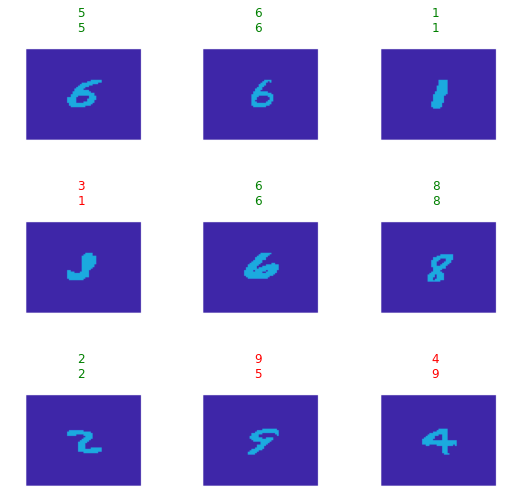

In [49]:
learn.show_results()

In order to verify performance, we will re run the predictions on our training set. 

In [25]:
correct = 0
incorrect = 0

for i in range(0,len(files)):
  if learn.predict(files[i])[0] == str(files[i])[-16]:
    correct = correct + 1
  else:
    incorrect = incorrect + 1
print(correct)
print(incorrect)

4847
153


Next, we will plot the confusion matrix.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

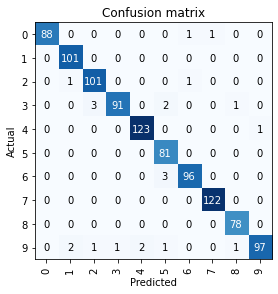

In [14]:
interp.plot_confusion_matrix()

Finally, we will make predictions on our test data sets.
This next cell will loop through the test set and compare the prediction scores for each number with the actual quantities of each. Finally, the accuracy will be computed.

In [40]:
PFA = Path(str(Test_Imagery) + '/PFA')
testfiles = get_image_files(PFA)

for i in range(0,len(testfiles)):
  number = str(testfiles[i])[-5]
  prediction = learn.predict(testfiles[i])
  print(number + '_' + str(prediction))

5_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.4470e-22, 0.0000e+00, 1.4398e-09, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.6088e-32, 0.0000e+00, 1.6473e-10, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.5632e-35, 0.0000e+00, 1.0594e-11, 0.0000e+00]))


5_('8', tensor(8), tensor([0.0000e+00, 9.8091e-45, 0.0000e+00, 0.0000e+00, 1.5285e-41, 0.0000e+00,
        2.7295e-30, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


3_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 1.3881e-14, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1709e-08, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


6_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.5559e-25, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


2_('2', tensor(2), tensor([1.4013e-45, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0009e-31, 0.0000e+00, 4.8065e-06, 0.0000e+00]))


3_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2928e-27, 0.0000e+00, 2.0498e-13, 0.0000e+00]))


0_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0753e-32, 0.0000e+00, 1.9298e-20, 0.0000e+00]))


5_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.0133e-33, 0.0000e+00, 4.9619e-09, 0.0000e+00]))


6_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 8.9271e-24, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.2766e-30, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


3_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 1.6818e-12, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.8248e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


6_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 3.8437e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5103e-17, 0.0000e+00, 9.9962e-01, 0.0000e+00]))


6_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 9.0144e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.9402e-28, 0.0000e+00, 9.8555e-02, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.2962e-35, 0.0000e+00, 5.2159e-19, 0.0000e+00]))


6_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 2.1202e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.8814e-26, 0.0000e+00, 9.9788e-01, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.9417e-38, 0.0000e+00]))


4_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 5.7435e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.4286e-21, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


2_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 2.2519e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.8459e-29, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.3383e-29, 0.0000e+00, 3.5251e-11, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.8590e-37, 0.0000e+00, 1.5948e-18, 0.0000e+00]))


4_('8', tensor(8), tensor([0.0000e+00, 8.6159e-41, 1.4580e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.7737e-23, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


0_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 3.2300e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0324e-25, 0.0000e+00, 6.7700e-01, 0.0000e+00]))


2_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.1669e-35, 0.0000e+00, 2.8700e-20, 0.0000e+00]))


4_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 6.3363e-33, 0.0000e+00]))


7_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4784e-42, 0.0000e+00,
        1.3875e-28, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


4_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.1259e-40, 0.0000e+00, 1.0548e-20, 0.0000e+00]))


4_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.9415e-43, 0.0000e+00, 1.5489e-23, 0.0000e+00]))


8_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.1616e-28, 0.0000e+00, 1.5984e-13, 0.0000e+00]))


7_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 5.2454e-28, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.4450e-35, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


3_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 9.9221e-25, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.4085e-09, 0.0000e+00, 1.0000e+00, 0.0000e+00]))


9_('2', tensor(2), tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1729e-41, 0.0000e+00, 2.3669e-18, 0.0000e+00]))


9_('8', tensor(8), tensor([0.0000e+00, 0.0000e+00, 2.0283e-40, 0.0000e+00, 4.2039e-45, 0.0000e+00,
        1.3736e-25, 0.0000e+00, 1.0000e+00, 0.0000e+00]))
